In [ ]:
%pip install -r requirements.txt

In [2]:
import os
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy.io.wavfile
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

## Loading and Displaying Audio Data

In [3]:
sample_audio_path = "./Audio_Speech_Actors_01-24/Actor_01"
sample_file = "03-01-05-02-01-02-01.wav"

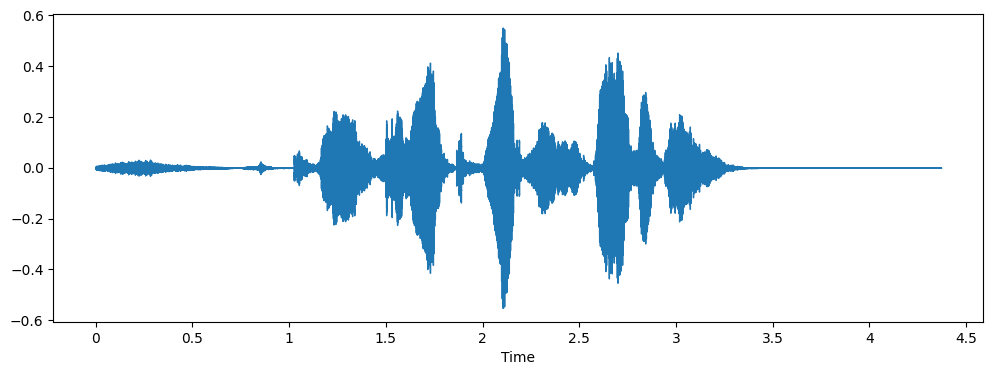

In [4]:
# Load and display the sample audio waveform
data, sampling_rate = librosa.load(os.path.join(sample_audio_path, sample_file))
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

### Calculate and display the spectrogram

/var/folders/pc/1h9xlpvd7rd5xtvc_7rkfznr0000gn/T/ipykernel_99225/3433933748.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, x = scipy.io.wavfile.read(os.path.join(sample_audio_path, sample_file))


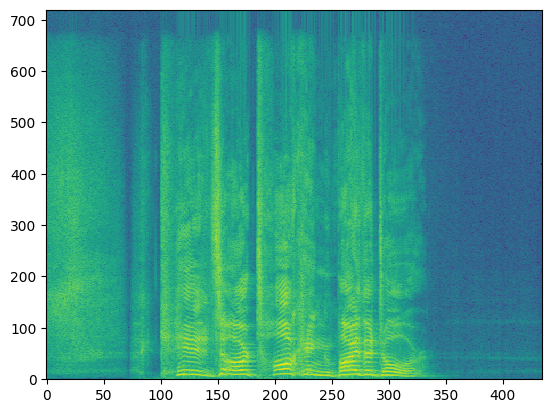

In [5]:
sr, x = scipy.io.wavfile.read(os.path.join(sample_audio_path, sample_file))
nstep = int(sr * 0.01)
nwin = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)

X = np.zeros((len(nn), nfft // 2))
for i, n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i, :] = np.log(np.abs(z[:nfft // 2]))

plt.imshow(X.T, interpolation='nearest', origin='lower', aspect='auto')
plt.show()

## Feature Extraction

In [6]:
# Extract features (MFCCs) from the audio files and store them in a list
path = sample_audio_path
lst = []
start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            X, sample_rate = librosa.load(os.path.join(subdir, file), res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            label = int(file[7:8]) - 1  # Convert labels from 1-8 to 0-7
            lst.append((mfccs, label))
        except ValueError:
            continue

print(f"--- Data loaded. Loading time: {time.time() - start_time:.2f} seconds ---")

--- Data loaded. Loading time: 2.78 seconds ---


In [7]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [8]:
save_dir = 'Saved_Models'
os.makedirs(save_dir, exist_ok=True)
joblib.dump(X, os.path.join(save_dir, 'X.joblib'))
joblib.dump(y, os.path.join(save_dir, 'y.joblib'))

['Saved_Models/y.joblib']

In [9]:
X = joblib.load(os.path.join(save_dir, 'X.joblib'))
y = joblib.load(os.path.join(save_dir, 'y.joblib'))

## Split the Data into Training and Testing Sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

## Model Training and Evaluation

### Decision Tree Model

In [11]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)
print(classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.25      0.50      0.33         2
           3       0.50      0.25      0.33         4
           4       0.50      0.67      0.57         3
           5       0.67      0.50      0.57         4
           6       0.00      0.00      0.00         2
           7       0.20      0.50      0.29         2

    accuracy                           0.39        18
   macro avg       0.30      0.35      0.30        18
weighted avg       0.39      0.39      0.37        18



### Random Forest Model

In [12]:
rforest = RandomForestClassifier(
    criterion="gini", max_depth=10, max_features="log2", max_leaf_nodes=100,
    min_samples_leaf=3, min_samples_split=20, n_estimators=22000, random_state=5
)
rforest.fit(X_train, y_train)
predictions = rforest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.20      0.50      0.29         2
           3       0.00      0.00      0.00         4
           4       1.00      0.67      0.80         3
           5       1.00      0.25      0.40         4
           6       0.67      1.00      0.80         2
           7       0.50      0.50      0.50         2

    accuracy                           0.39        18
   macro avg       0.42      0.36      0.35        18
weighted avg       0.54      0.39      0.40        18



### Neural Network Model

In [13]:
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

model = Sequential([
    tensorflow.keras.layers.Input(shape=(40, 1)),
    Conv1D(128, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=8),
    Conv1D(128, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    Flatten(),
    Dense(8),
    Activation('softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(X_train_cnn, y_train, batch_size=16, epochs=1000, validation_data=(X_test_cnn, y_test))

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1339 - loss: 22.2534 - val_accuracy: 0.1111 - val_loss: 15.7081
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1101 - loss: 21.4439 - val_accuracy: 0.1111 - val_loss: 13.8757
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0986 - loss: 21.8527 - val_accuracy: 0.0000e+00 - val_loss: 12.3189
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1023 - loss: 20.7987 - val_accuracy: 0.1111 - val_loss: 8.1472
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0748 - loss: 13.0635 - val_accuracy: 0.1667 - val_loss: 8.6734
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1853 - loss: 10.9217 - val_accuracy: 0.0556 - val_loss: 7.9534
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2087 - loss: 10.6747 - val_accuracy: 0.1667 - val_loss: 5.0184
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1064 - loss: 7.8041 - val_accuracy: 0.

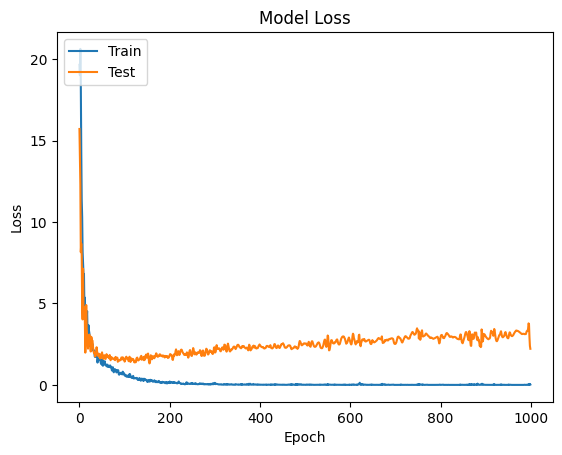

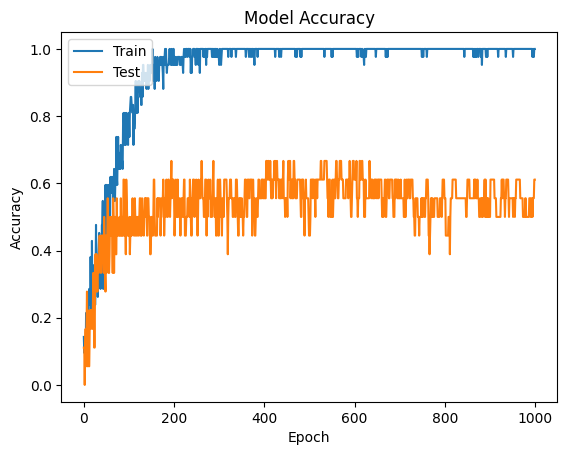

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
predictions = np.argmax(model.predict(X_test_cnn), axis=1)
print(classification_report(y_test.astype(int), predictions, zero_division=0))
print(confusion_matrix(y_test.astype(int), predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         0
           2       0.67      1.00      0.80         2
           3       1.00      0.25      0.40         4
           4       0.67      0.67      0.67         3
           5       1.00      0.50      0.67         4
           6       1.00      0.50      0.67         2
           7       0.33      1.00      0.50         2

    accuracy                           0.61        18
   macro avg       0.71      0.61      0.59        18
weighted avg       0.83      0.61      0.62        18

[[1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0]
 [0 0 0 1 0 0 0 3]
 [0 0 0 0 2 0 0 1]
 [0 1 1 0 0 2 0 0]
 [0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 2]]


## Save the Trained Model

In [17]:
model_name = 'Emotion_Voice_Detection_Model.keras'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print(f'Saved trained model at {model_path}')

Saved trained model at Saved_Models/Emotion_Voice_Detection_Model.keras


In [18]:
loaded_model = tensorflow.keras.models.load_model(model_path)
loaded_model.summary()
loss, acc = loaded_model.evaluate(X_test_cnn, y_test)
print(f"Restored model, accuracy: {acc * 100:.2f}%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         5,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,834 (1.01 MB)

 Trainable params: 87,944 (343.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 175,890 (687.07 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6111 - loss: 2.2179
Restored model, accuracy: 61.11%
